In [151]:
import pandas as pd

df = pd.read_csv('car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [152]:
df

,make,transmission,state,condition,odometer,auction_value,selling_price
0,nissan,automatic,md,4.8,NaN,14350.0,13600.0
1,ford,automatic,mo,3.7,29398.0,17600.0,17100.0
2,ford,automatic,fl,3.2,32180.0,19100.0,17600.0
3,nissan,automatic,ca,NaN,30798.0,11950.0,10700.0
4,ford,automatic,nj,2.8,29526.0,28000.0,26100.0
...,...,...,...,...,...,...,...
9050,NaN,automatic,il,4.2,41186.0,NaN,11600.0
9051,ford,automatic,fl,NaN,38810.0,16250.0,17300.0
9052,nissan,NaN,ga,4.7,4551.0,12500.0,13800.0
9053,ford,automatic,il,4.6,33114.0,21800.0,27000.0


In [153]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [154]:
# insert code here
X_train

,make,transmission,state,condition,odometer,auction_value
7821,kia,automatic,wi,4.4,NaN,13800.0
4127,chrysler,automatic,ca,4.3,27368.0,21300.0
12,ford,automatic,fl,2.8,66470.0,10300.0
1689,honda,automatic,NaN,3.6,25208.0,12900.0
726,hyundai,automatic,NaN,3.3,41234.0,11750.0
...,...,...,...,...,...,...
350,hyundai,automatic,wi,NaN,49411.0,11650.0
79,NaN,NaN,NaN,4.3,36731.0,17600.0
8039,nissan,automatic,oh,4.2,41269.0,11750.0
6936,dodge,automatic,fl,3.5,53997.0,9550.0


In [155]:
df_numerical = X_train.select_dtypes(exclude= "object")

In [156]:
df_categorical = X_train.select_dtypes(include='object')

In [157]:
df_numerical_cols = df_numerical.columns.tolist()
df_categorical_cols = df_categorical.columns.tolist()

In [158]:
df_numerical_cols

['condition', 'odometer', 'auction_value']

In [159]:
df_categorical_cols

['make', 'transmission', 'state']

## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [160]:
# insert code here

X_train.isna().sum()

make             729
transmission     758
state            703
condition        686
odometer         703
auction_value    771
dtype: int64

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('scale', StandardScaler())
                        ])

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [96]:
# insert code here

car_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])



In [162]:
car_pipeline.fit_transform(X_train[df_categorical_cols])[0,:].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [163]:
car_pipeline.fit_transform(X_train[df_categorical_cols])

<7244x41 sparse matrix of type '<class 'numpy.float64'>'
	with 14213 stored elements in Compressed Sparse Row format>

## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [149]:
# insert code here

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, df_numerical_cols),
                                                      ('create_dummies', car_pipeline, df_categorical_cols)])
modeling_pipeline = Pipeline([('data_processing', processing_pipeline)])


In [164]:
processing_pipeline.fit_transform(X_train).shape

(7244, 44)

## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [99]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline( [('data_processing', processing_pipeline),('lm', LinearRegression())])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                  

In [100]:
sellprice_predictions = modeling_pipeline.predict(X_test)

In [101]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, sellprice_predictions)
print(mse)

6998122.044323062


In [102]:
rmse = np.sqrt(mse)
rmse

2645.396386994407

In [103]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, sellprice_predictions)
r2

0.8838274422416588

## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

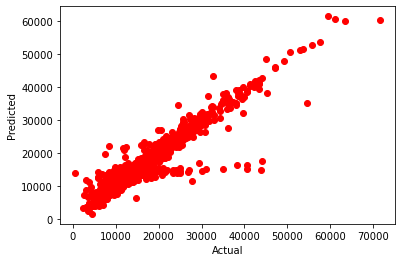

In [106]:
# insert code here
import matplotlib.pyplot as plt

plt.plot(y_test, sellprice_predictions, 'ro')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

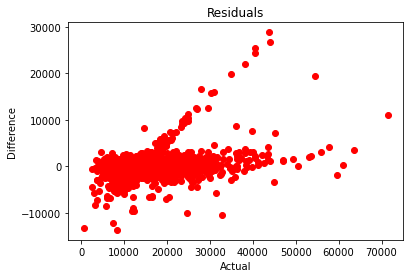

In [150]:
diff= y_test- sellprice_predictions
plt.plot(y_test,diff,'ro')
plt.title('Residuals')
plt.xlabel('Actual')
plt.ylabel('Difference')
plt.show()

Plot shows there are groups of values for which actual values are between 20000-45000 but the model predicted them as 15000. Also we can't ignore some of the overpredicted values.

## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [141]:
from collections import defaultdict
from sklearn.linear_model import Ridge


modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=100))])
modeling_pipeline_ridge.fit(X_train, y_train)
ridge_training_score = modeling_pipeline_ridge.score(X_train, y_train)
ridge_test_score = modeling_pipeline_ridge.score(X_test, y_test)

In [148]:
ridge_test_score

0.8824295262289528

There is very little change in R2 value after ridge regression that is 0.0014.